## Analog discovery using Simba

Modern metabolomics relies on tandem mass spectrometry (MS/MS) to identify the structures of small molecules in complex biological samples. While exact spectral matching against large reference libraries can confidently identify known compounds, discovering analogs, molecules with similar but not identical structures, remains a significant challenge. Analog search is crucial for applications ranging from drug lead optimization to biomarker discovery, where small structural changes can produce different biological effects.

**SIMBA** (Spectral Identification of Molecule Bio-Analogues) is a deep-learning framework designed to bridge this gap. Rather than rely only on heuristic scores like modified cosine, SIMBA’s twin‐transformer architecture learns to predict two chemically interpretable metrics directly from MS/MS spectra:

1. **Substructure Edit Distance (SED):** the minimal number of bond edits (additions/removals) needed to transform one molecule into another via their Maximum Common Substructure (MCS).  
2. **Maximum Common Edge Subgraph (MCES) Distance:** the count of bond differences outside the shared subgraph, offering a complementary view of structural similarity.

This notebook walks you through a typical analog-discovery workflow using SIMBA:

1. **Compute Spectral Embeddings**  
   We begin by computing the MS/MS embeddings generated by SIMBA’s transformer encoders for both query and reference spectra.

2. **Perform Analog Search**  
   We compute pairwise MCES and SED predictions between query spectra (e.g., from the CASMI benchmark) and a reference library ( MassSpecGym) and rank candidates by structural distance.

3. **Evaluate examples**  
   We evaluate some examples of the matches found by SIMBA.

By the end of this notebook, you’ll see how SIMBA’s learned similarity metrics enable more sensitive and interpretable analog retrieval.


In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Libraries

In [9]:
import simba
from simba.config import Config
from simba.simba.simba import Simba
from simba.simba.preprocessing_simba import PreprocessingSimba
from simba.simba.plotting import Plotting
from simba.simba.analog_discovery import AnalogDiscovery
import numpy as np
import spectrum_utils.plot as sup
from rdkit import Chem
from simba.simba.ground_truth import GroundTruth
import matplotlib.pyplot as plt
import spectrum_utils.plot as sup

## Defining parameters

Define the default configuration variables

In [10]:
config=Config()
config.USE_LEARNABLE_MULTITASK=True
config.USE_FINGERPRINT=False

Location of model saved, reference spectra in mgf file (MASSSPECGYM), an query spectra (CASMI)

In [11]:
model_location = '/Users/sebas/projects/data/best_model_20250422_only_massspecgym.ckpt'
reference_file = '/Users/sebas/projects/data/MassSpecGym.mgf'
casmi_file= '/Users/sebas/projects/data/processed_massformer/casmi2022_spec_df.pkl' 

## Load spectra

Let's load the reference spectra and query spectra. This code already carries out a preprocessing of the files obtaining only protonized adducts and spectra with at least more than 6 peaks.

In [12]:
all_spectrums_reference=PreprocessingSimba.load_spectra(reference_file, config, use_gnps_format=False)

/Users/sebas/projects/data/MassSpecGym.mgf
File name ends with mgf


 32%|████████████████████████████████████████████████████▌                                                                                                                | 159139/500000 [00:39<01:24, 4050.40it/s]


We reached the end of the array at index 159139


In [13]:
print(f'Number of spectra loaded from reference: {len(all_spectrums_reference)}')

Number of spectra loaded from reference: 133215


In [14]:
all_spectrums_query=PreprocessingSimba.load_spectra(casmi_file, config, use_gnps_format=False)

/Users/sebas/projects/data/processed_massformer/casmi2022_spec_df.pkl


In [15]:
print(f'Number of spectra loaded from query: {len(all_spectrums_query)}')

Number of spectra loaded from query: 158


##  Let's check some spectra visually

In [16]:
all_spectrums_query[2].params

{'spectrumid': '10 M+H',
 'name': '10 M+H',
 'inchi': '',
 'organism': 'casmi',
 'id': 10,
 'smiles': 'Cn1c(CNc2ccc(C(=N)N)cc2)nc2cc(C(=O)N(CCC(=O)O)c3ccccn3)ccc21',
 'ionmode': 'Positive',
 'pepmass': [472.208379934413],
 'charge': [1],
 'libraryquality': 1}

<Axes: xlabel='m/z', ylabel='Intensity'>

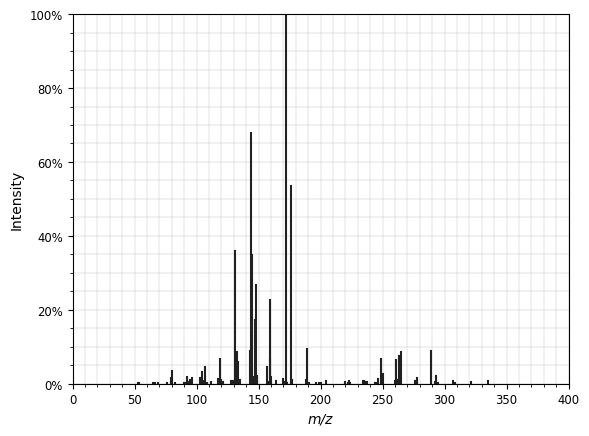

In [17]:
sup.spectrum(all_spectrums_query[2])

## Initialize model

Here we load a simba model based on path specified in 'model_location'. The device to be used is set to 'cpu' unless you have access to a configures GPU. The argument cache_embeddings, allows to reuse embeddings already computed to accelerate future library searchs.

In [18]:
simba_model= Simba(model_location, config=config, device='cpu', cache_embeddings=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:177: Found keys that are not in the model state dict but in the checkpoint: ['log_sigma1', 'log_sigma2']


## Predictions

Based on the simba model created let's predict the substructure edit distance (sim_ed) and MCES distance (sim_mces)

In [19]:
sim_ed, sim_mces= simba_model.predict(all_spectrums_query, all_spectrums_reference, )

Preprocessing all the data ...


158it [00:00, 61577.78it/s]


Finished preprocessing 
loading data
Normalizing intensities
Preprocessing all the data ...


133215it [00:01, 91106.02it/s]


Finished preprocessing 
loading data


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/sebas/projects/metabolomics/notebooks/final_tutorials/lightning_logs


Normalizing intensities
running
Processing embeddings ...


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

/Users/sebas/projects/metabolomics/simba/transformers/spectrum_transformer_encoder_custom.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mass_precursor = torch.tensor(kwargs["precursor_mass"].float())
/Users/sebas/projects/metabolomics/simba/transformers/spectrum_transformer_encoder_custom.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  charge_precursor = torch.tensor(kwargs["precursor_charge"].float())
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytor

running
Processing embeddings ...


Predicting: |                                                                                                 …

158it [00:53,  2.96it/s]


Elapsed time: 53.52 seconds


In [20]:
sim_mces

array([[31.99556828, 31.61935508, 33.14300716, ..., 28.28802705,
        27.21589804, 26.34391546],
       [13.39839458, 14.84078407, 10.70658684, ..., 23.21400881,
        23.61002684, 21.94936037],
       [19.06649828, 19.78633642, 19.52608824, ..., 23.2039845 ,
        24.66819286, 23.77721548],
       ...,
       [12.14192867, 13.74958992, 10.67453623, ..., 21.33901358,
        21.99141145, 20.61288118],
       [16.25313997, 15.27415752, 17.05640316, ..., 17.15052128,
        16.48262024, 16.78530455],
       [14.55783606, 12.95701504, 14.24300909, ..., 20.98487139,
        21.07420206, 19.27678347]])

The predictions of substructure edit distance are discretized between 0 and 5, being 5 having five or more modifications and 0 having zero modifications. Let's take 10,000 random predictions and check the distribution of the results. Higher substructure edit distances are more common since related molecules are scarse normally.

Text(0, 0.5, 'Frequency')

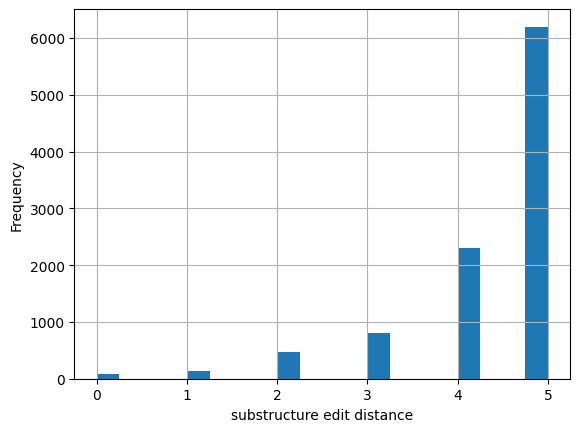

In [21]:
flat = sim_ed.ravel()                            # view as 1-D array of length M*N
idx = np.random.choice(flat.size, size=10000, replace=False)
samples_ed = flat[idx]
plt.hist(samples_ed, bins=20)
plt.grid()
plt.xlabel('substructure edit distance')
plt.ylabel('Frequency')

The predictions of MCES distance are constrained to 0 to 40 edges. Let's take 10,000 random predictions and check the distribution of the results. Higher MCES distances are more common since related molecules are scarse normally.

Text(0, 0.5, 'Frequency')

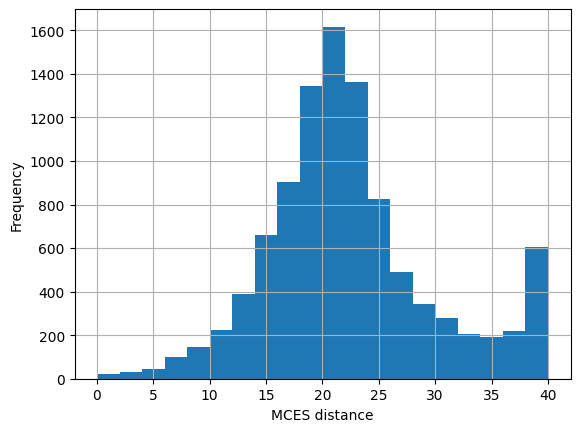

In [22]:
flat = sim_mces.ravel()                            # view as 1-D array of length M*N
idx = np.random.choice(flat.size, size=10000, replace=False)
samples_mces = flat[idx]
plt.hist(samples_mces, bins=20)
plt.grid()
plt.xlabel('MCES distance')
plt.ylabel('Frequency')

## Reranking

Based on the predictions of MCES and Edit distance we can rerank the results. Lower MCES distance and lower edit distances are higher in the rank. The MCES distance is used as primary metric to rank the predictions given its finer granularity. If 2 predictions have the same MCES distance, the one with the lower substructure edit distance is ranked higher.

In [23]:
ranking= AnalogDiscovery.compute_ranking(sim_mces, sim_ed)

The rank is scaled to 0-1 (normalized to the number of comparisons with the reference library), where 1 means the highest ranking and 0 the lowest ranking.

In [24]:
ranking.shape

(158, 133215)

Text(0, 0.5, 'Frequency')

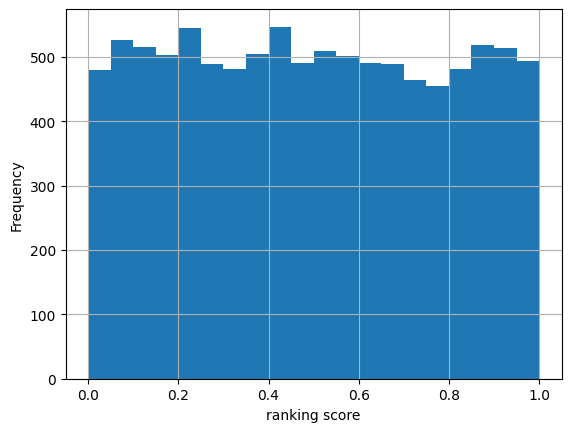

In [25]:
flat = ranking.ravel()                            # view as 1-D array of length M*N
idx = np.random.choice(flat.size, size=10000, replace=False)
samples_mces = flat[idx]
plt.hist(samples_mces, bins=20)
plt.grid()
plt.xlabel('ranking score')
plt.ylabel('Frequency')

## What is the matched spectra in the reference library for each query spectra?

If we want to find this answer, we have to first select the query spectra we are interested. We can define a variable 'target_index' which indicates the position of the spectrum in the spectra loaded. From there, we can select the 10 highest SIMBA scores and filtering the match with the lowest MCES distance

In [26]:
target_index=2

In [27]:
spectra_query= all_spectrums_query[target_index]

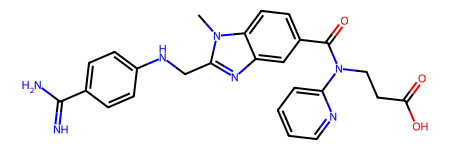

In [28]:
Chem.MolFromSmiles(spectra_query.params['smiles'])

Let's checkwhat are the predictions of the model for this specific query spectra. These are the ranking scores generated for the query spectra selected:

In [29]:
ranking[target_index]

array([0.94007432, 0.92828886, 0.93234996, ..., 0.65009946, 0.44550539,
       0.55890853])

In [30]:
ranking[target_index].shape

(133215,)

Between all the comparisons, we can select the 10 highest scores

In [31]:
best_matches= np.argsort(ranking[target_index])[-10:]

In [32]:
best_matches

array([109568,  95729, 113063,  90086, 101584, 105758, 112947,  92083,
       105759, 101585])

In [33]:
spectra_matches = [all_spectrums_reference[ind] for ind in best_matches]

Let's compute the MCES distances for the matches found and select the best

In [34]:
ground_truth_mces=GroundTruth.compute_mces([spectra_query], spectra_matches)

Running myopic ...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/4x/y1dnj1n55js4gtv69lsx4g4h0000gn/T/5ef84688e27746cf8bfa08606ae69c34-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/4x/y1dnj1n55js4gtv69lsx4g4h0000gn/T/5ef84688e27746cf8bfa08606ae69c34-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2698 COLUMNS
At line 13932 RHS
At line 16626 BOUNDS
At line 17944 ENDATA
Problem MODEL has 2693 rows, 1317 columns and 8272 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.14 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.15   (Wallclock seconds):       0.15

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/s

In [35]:
ground_truth_mces

array([[28. , 20. , 20. , 31.5, 20. ,  2. , 29. , 20. ,  2. , 20. ]])

Let's select the lowest MCES distance

In [36]:
best_match_index = best_matches[np.argmin(ground_truth_mces)]

In [37]:
best_match_index

105758

In [38]:
spectra_match= spectra_matches[np.argmin(ground_truth_mces)]

This is the index in the reference spectra with the best match:

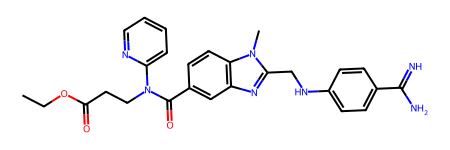

In [39]:
Chem.MolFromSmiles(spectra_match.params['smiles'])

Now take a look at what the model predicts in terms of substructure edit distance and MCES distance for this specfic comparison:

In [40]:
print(f'The MCES distance predicted is: {np.round(sim_mces[target_index, best_match_index])}')

The MCES distance predicted is: 2.0


In [41]:
print(f'The substructure edit distance predicted is: {sim_ed[target_index, best_match_index]}')

The substructure edit distance predicted is: 0


## Comparison with ground truth

We can check what is the ground truth edit distance and MCES distance:

In [42]:
ground_truth_mces=GroundTruth.compute_mces([spectra_query], [spectra_match])

Running myopic ...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/4x/y1dnj1n55js4gtv69lsx4g4h0000gn/T/cde8d57d4f6c4e4eb31f2d165323e91b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/4x/y1dnj1n55js4gtv69lsx4g4h0000gn/T/cde8d57d4f6c4e4eb31f2d165323e91b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2962 COLUMNS
At line 15589 RHS
At line 18547 BOUNDS
At line 20029 ENDATA
Problem MODEL has 2957 rows, 1481 columns and 9294 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2 - 0.03 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 82 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 82 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 8 strengthened rows, 0 s

In [43]:
print(f'The real MCES distance is: {ground_truth_mces[0,0]}')

The real MCES distance is: 2.0


In [44]:
ground_truth_ed=GroundTruth.compute_edit_distance([spectra_query], [spectra_match])

In [45]:
print(f'The real edit distance is: {ground_truth_ed[0,0]}')

The real edit distance is: 1.0


## Comparison predicted vs ground truth

In [46]:
print(f'MCES: Ground truth: {ground_truth_mces[0,0]}, predicted {np.round(sim_mces[target_index, best_match_index])}')

MCES: Ground truth: 2.0, predicted 2.0


In [47]:
print(f'Edit distance: Ground truth: {ground_truth_ed[0,0]}, predicted {np.round(sim_ed[target_index, best_match_index])}')

Edit distance: Ground truth: 1.0, predicted 0


## How it looks like the spectra that is found as match?

<Axes: xlabel='m/z', ylabel='Intensity'>

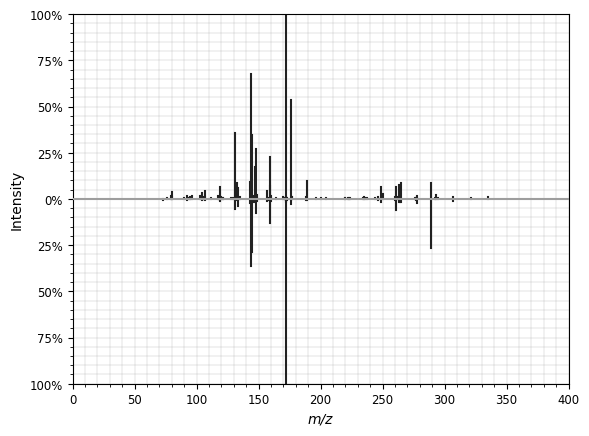

In [48]:
sup.mirror(spectra_query, spectra_match)